In [1]:
%load_ext autoreload
%autoreload 2

# Space Charge Benchmark

Reproduce plots in:

C. E. Mayes, R. D. Ryne, D. C. Sagan, *3D Space Charge in Bmad*, IPAC2018, Vancouver, BC, Canada
https://accelconf.web.cern.ch/ipac2018/papers/thpak085.pdf

Also see:
https://arxiv.org/pdf/1111.4971.pdf

In [2]:
from spacecharge.freespace import igf_mesh3, spacecharge_mesh
from spacecharge.deposit import deposit_particles
from spacecharge.testing import test_particles

In [3]:
import numpy as np

from scipy.signal import fftconvolve, oaconvolve
from scipy.interpolate import interpn
import scipy.fft as sp_fft

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
%config InlineBackend.figure_format = 'retina'

# Create Gaussian particles

In [4]:
RATIO = 4

NP = 10000000
# Beam sizes in m
SIGX = 0.001
SIGY = 0.001
SIGZ = 0.001 * RATIO 
CHARGE = 1e-9 # C

BINS = (128,128,128)

particles, weights = test_particles(n_particle=NP, sigma_x=SIGX, sigma_y=SIGY, sigma_z=SIGZ,
                                total_charge=CHARGE)

particles.shape

(10000000, 3)

In [5]:
# Check particles/bin.
NP/np.prod(BINS)

4.76837158203125

In [6]:
particles[:,2].min()/SIGZ, particles[:,2].max()/SIGZ

(-5.182134543931297, 5.3526157271604635)

In [7]:
rho_mesh, deltas, coord_vecs = deposit_particles(particles, weights=weights, bins=BINS)
rho_mesh.shape, deltas

((128, 128, 128), array([7.98573312e-05, 8.34768160e-05, 3.29210946e-04]))

In [8]:
# Coordinate meshes
X, Y, Z = np.meshgrid(*coord_vecs, indexing='ij') 

In [9]:
from spacecharge.freespace import igf_mesh3

In [10]:
deltas

array([7.98573312e-05, 8.34768160e-05, 3.29210946e-04])

In [11]:
np.arange(0,2,1)

array([0, 1])

# Green function

The Green function is computed internally. Here we will examine it.

In [12]:
%%time
Gx = igf_mesh3(rho_mesh.shape, deltas, component='x') 
Gx.shape

CPU times: user 1.52 s, sys: 852 ms, total: 2.37 s
Wall time: 2.38 s


(256, 256, 256)

In [13]:
# The center point was evaluated at the origin x=0,y=0,z=0
ix_center = tuple([(n-1)//2 for n in Gx.shape])
ix_center

(127, 127, 127)

In [14]:
# This should be zero or near zero by symmetry
Gx[ix_center]

-9.88064587879518e-08

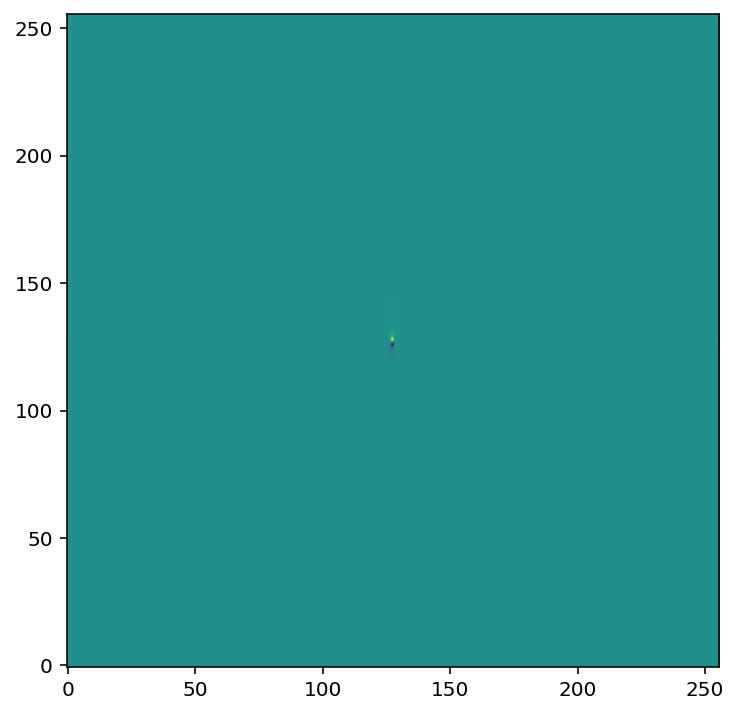

In [15]:
plt.imshow(Gx[:,ix_center[1],:], origin='lower')

<ipython-input-16-c7466af03d5c>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(Gx[:,ix_center[1],:])), origin='lower')


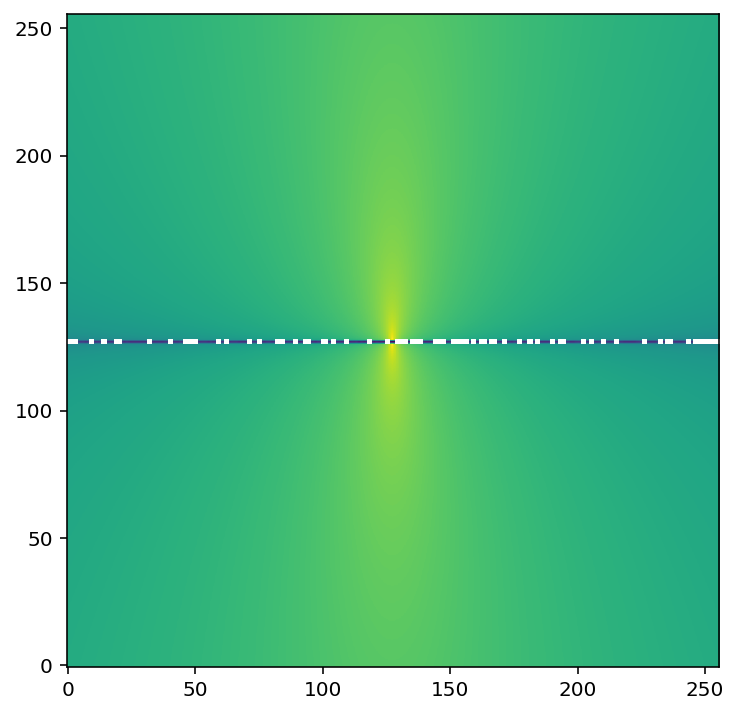

In [16]:
# Use log to show more
plt.imshow(np.log(np.abs(Gx[:,ix_center[1],:])), origin='lower')

# Convolution

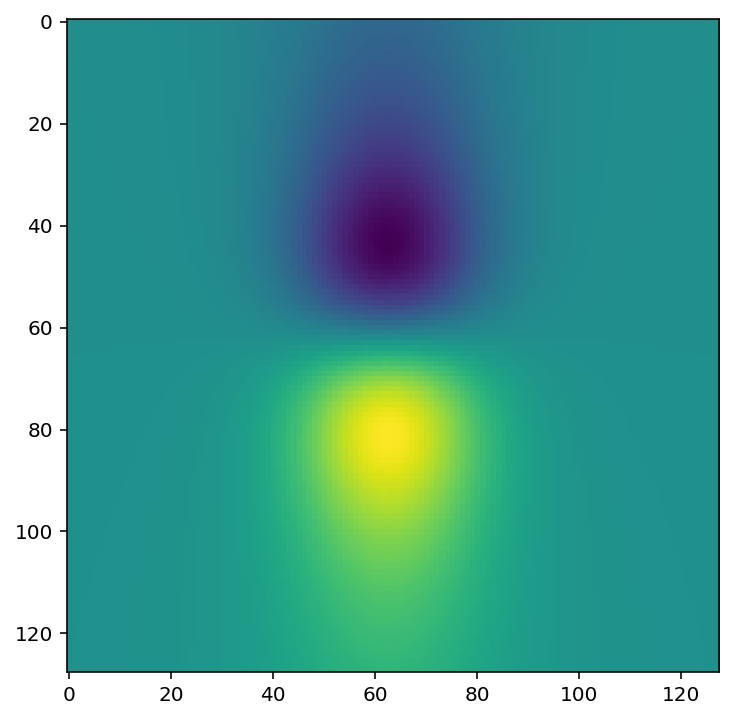

In [17]:
field1=fftconvolve(rho_mesh, Gx, mode='same')

plt.imshow(field1[:,BINS[1]//2,:])

In [18]:
# Alternatively, the FFT convolution can be done explicitly. 

# Create an array of the same size as the Green function, 
# and place the rho mesh in the first octant
def zero_pad(a, shape):
    a2 = np.zeros(shape)
    a2[:a.shape[0],:a.shape[1],:a.shape[2]] = a[:a.shape[0],:a.shape[1],:a.shape[2]]
    return a2

R2 = zero_pad(rho_mesh, Gx.shape)

# The result will be found with this offset
offset = BINS[0]-1 ,BINS[1]-1, BINS[2]-1

field2 = np.real(
    sp_fft.ifftn(sp_fft.fftn(R2)*sp_fft.fftn(Gx))[offset[0]:offset[0]+BINS[0],
                                                     offset[1]:offset[1]+BINS[1],
                                                     offset[2]:offset[2]+BINS[2]]
)
BINS, R2.shape, Gx.shape, field2.shape

((128, 128, 128), (256, 256, 256), (256, 256, 256), (128, 128, 128))

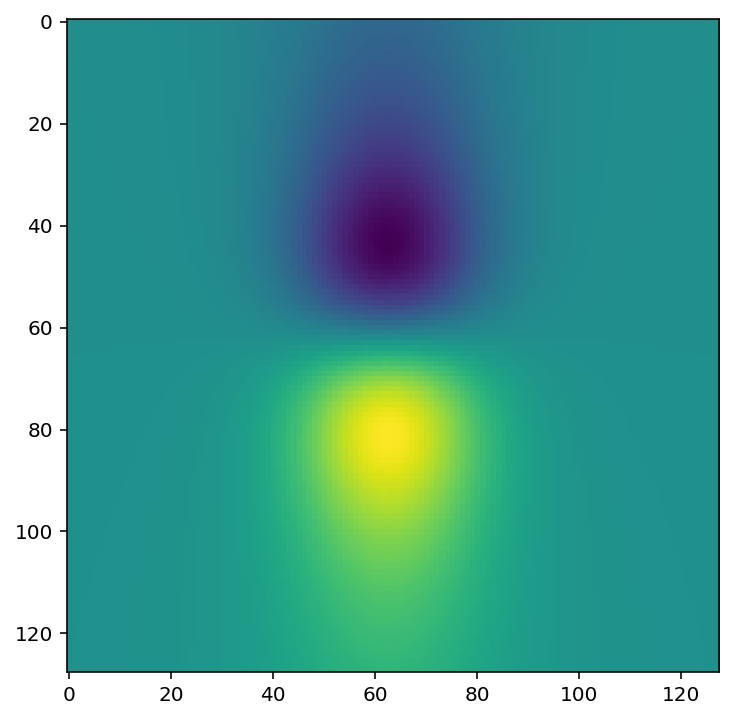

In [19]:
plt.imshow(field2[:,BINS[1]//2,:])

In [20]:
# The results are the same
np.abs(field2-field1).max()

8.131516293641283e-20

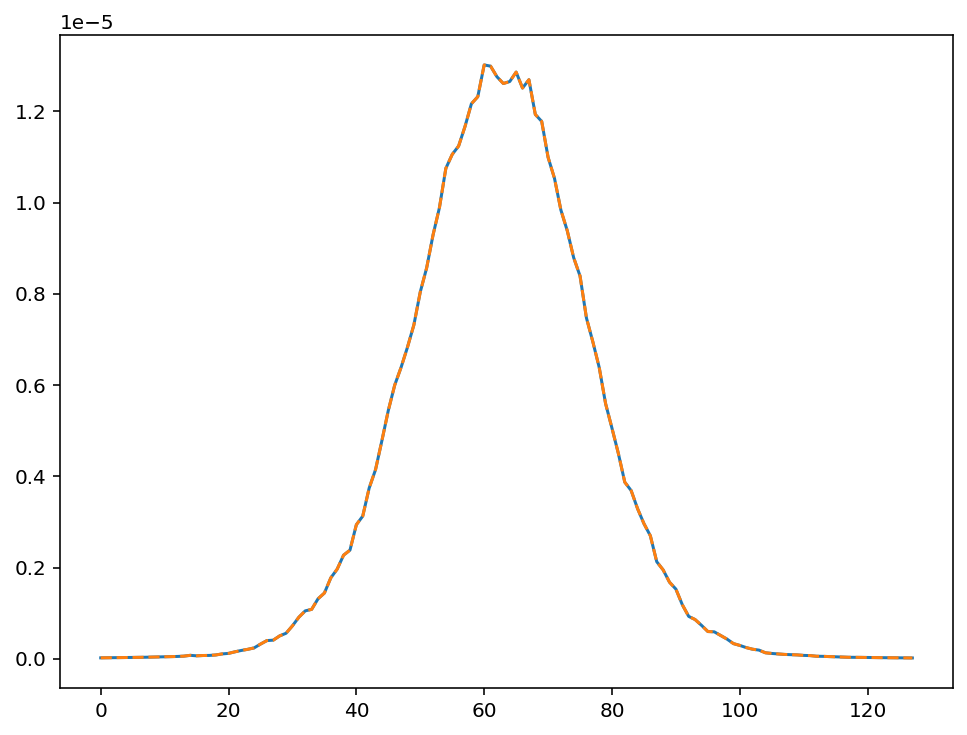

In [21]:
plt.plot(field1[BINS[0]//2,BINS[1]//2,:])
plt.plot(field2[BINS[0]//2,BINS[1]//2,:], linestyle='--')

# Space Charge mesh

In [ ]:
%%time
Ex_mesh = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='x')

In [ ]:
%%time
Ey_mesh = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='y')

In [ ]:
%%time
Ez_mesh = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='z')

In [ ]:
plt.imshow(Ez_mesh[:,BINS[1]//2,:]/1e6, origin='lower')
plt.title(r'$E_z$' +' mesh on the y=0 plane')
plt.colorbar(label=r'$E_z$'+' (MV/m)')

In [ ]:
plt.imshow(Ex_mesh[:,BINS[1]//2,:]/1e6, origin='lower')
plt.title(r'$E_x$' +' mesh on the y=0 plane')
plt.colorbar(label=r'$E_x$'+' (MV/m)')

In [ ]:
iy =  BINS[1]//2 
print(iy)

Emag = np.sqrt((Ex_mesh[:,iy,:]**2 + Ey_mesh[:,iy,:]**2 + Ez_mesh[:,iy,:]**2))

plt.imshow(Emag/1e6, origin='lower')
plt.title(r'$|E|$' +' mesh on the y=0 plane')
plt.colorbar(label=r'$|E|$'+' (MV/m)')

In [ ]:
x0 = np.linspace(coord_vecs[0].min(), coord_vecs[0].max() , 100)
xpts = np.array([[x, 0,0] for x in x0])

# Plot on x=0, y=0 line
Ex0 = interpn(coord_vecs, Ex_mesh, xpts)

fig, ax = plt.subplots()
ax.plot(x0/SIGX, Ex0/1e6)

ax.set_title(r'$E_x$'+' along the y=0, z=0 line')
ax.set_xlim(-6, 6)
#ax.set_ylim(-10,10)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_x~(MV/m)$')



In [ ]:
z0 = np.linspace(coord_vecs[2].min(), coord_vecs[2].max() , 1000)
zpts = np.array([[0,0,z] for z in z0])

# Plot on x=0, y=0 line
Ez0 = interpn(coord_vecs, Ez_mesh, zpts)

fig, ax = plt.subplots()
ax.plot(z0/SIGZ, Ez0/1e6)

ax.set_title(r'$E_z$'+' along the x=0, y=0 line')
ax.set_xlim(-6, 6)
#ax.set_ylim(-10,10)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_z~(MV/m)$')

# Offset fields

Fields beyond the charge mesh can be calculated by adding an offset. This simply computes the green function with this offset.



In [ ]:
Ez_mesh0 = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='z', offset=(0,0,0))

zoffset1 = deltas[2]*20
zoffset2 = deltas[2]*40

zz0 = coord_vecs[2]
zz1 = coord_vecs[2]+zoffset1
zz2 = coord_vecs[2]+zoffset2

Ez_mesh1 = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='z', offset=(0,0,zoffset1))
Ez_mesh2 = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='z', offset=(0,0,zoffset2))

In [ ]:
plt.plot(zz0, Ez_mesh0[BINS[0]//2, BINS[1]//2,:])
plt.plot(zz1, Ez_mesh1[BINS[0]//2, BINS[1]//2,:], linestyle='--')
plt.plot(zz2, Ez_mesh2[BINS[0]//2, BINS[1]//2,:], linestyle='--')

# Mirror fields 

In [ ]:
rho_mesh2 = rho_mesh.copy()[:,:,BINS[2]//2:]#[:,:,::-1]

rho_mesh2_mirror = -rho_mesh2[:,:,::-1]

z0 = coord_vecs[2][BINS[2]//2:]
z0_mirror = z0 - z0.ptp()


shape = rho_mesh2.shape
shape, z0.shape

In [ ]:
zdensity = np.sum(np.sum(rho_mesh2, axis=1), axis=0)
zdensity_mirror = np.sum(np.sum(rho_mesh2_mirror, axis=1), axis=0)

fig, ax = plt.subplots(figsize=(12,4))
ax.fill_between(z0, 0, zdensity, alpha=0.5)
ax.fill_between(z0_mirror, 0, zdensity_mirror, alpha=0.5)
ax.set_ylabel('Charge density')
ax.set_xlabel('z (m)')

In [ ]:
plt.imshow(rho_mesh2[:,shape[1]//2,:])
plt.title(r'$\rho$' +' mesh on the y=0 plane')
#plt.colorbar(label=r'$E_z$'+' (MV/m)')

In [ ]:
zwidth = z0.ptp()

Ez_mesh0 = spacecharge_mesh(rho_mesh2, deltas, gamma=1, component='z', offset=(0,0,0))
Ez_meshMirror0 = spacecharge_mesh(rho_mesh2_mirror, deltas, gamma=1, component='z', offset=(0,0,0))
Ez_meshMirror1 = spacecharge_mesh(rho_mesh2_mirror, deltas, gamma=1, component='z', offset=(0,0,zwidth))
Ez_mesh0_total = Ez_mesh0 + Ez_meshMirror1

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

ax2 = ax.twinx()
ax2.fill_between(z0, 0, zdensity, alpha = 0.3, color='blue')
ax2.fill_between(z0_mirror, 0, zdensity_mirror, alpha = 0.3, color='red')

ax.plot(z0, Ez_mesh0[shape[0]//2, shape[1]//2,:], label='real bunch field', marker='.', color='blue')

ax.plot(z0, Ez_meshMirror1[shape[0]//2, shape[1]//2,:], label='mirror field extended', marker='x', color='red')
ax.plot(z0-zwidth, Ez_meshMirror0[shape[0]//2, shape[1]//2,:], label='mirror field left', marker='.', color='red')
ax.plot(z0, Ez_mesh0_total[shape[0]//2, shape[1]//2,:], label='total field', marker='.', color='black')


ax.legend()
ax.set_title('Cathode field using image (mirror) charges')
ax.set_ylabel(r'$E_z$'+' (V/m)')
ax.set_xlabel('z (m)')
#ax.set_xlim(-.001,.0001)

In [ ]:
plt.imshow(Ez_mesh0_total[:,shape[1]//2,:]/1e6, origin='lower', aspect='auto')
plt.title('Total '+r'$E_z$' +' mesh on the y=0 plane')
plt.colorbar(label=r'$E_z$'+' (MV/m)')

# Summary plots

In [ ]:
# Ex 
x0 = np.linspace(coord_vecs[0].min(), coord_vecs[0].max() , 1000)
xpts = np.array([[x,0,0] for x in x0])

fig, ax = plt.subplots(figsize=(8,5))

COLOR = {1:'black', 0.1:'blue', 0.01: 'purple', 10:'red'}

for ratio in [.01, .1, 1, 10]:
    deltas0 = deltas.copy()
    deltas0[2] *= ratio
    Ex_mesh = spacecharge_mesh(rho_mesh, deltas0, gamma=1, component='x')

    Ex0 = interpn(coord_vecs, Ex_mesh, xpts)
    
    ax.plot(x0/SIGX, Ex0/1e6, color=COLOR[ratio], label=f'{ratio}')
    
    
# Charge density    
#ax2 = ax.twinx()      
H, edges = np.histogram(particles[:, 0], bins=100)
ax.fill_between(edges[1:]/SIGX, 0, H/H.max()*8, color='gray', alpha=0.2)    

ax.set_xlim(-6, 6)
ax.set_ylim(-10,10)    
ax.set_xlabel(r'$x/\sigma_x$')
ax.set_ylabel(r'$E_x$'+' (MV/m)')    
ax.legend(title='r')

In [ ]:
# Ez 
z0 = np.linspace(coord_vecs[2].min(), coord_vecs[2].max() , 1000)
zpts = np.array([[0,0,z] for z in z0])

fig, ax = plt.subplots(figsize=(8,5))

COLOR = {1:'black', 0.1:'blue', 0.01: 'purple', 10:'red'}

for ratio in [.01, .1, 1, 10]:
    deltas0 = deltas.copy()
    deltas0[2] *= ratio
    Ez_mesh = spacecharge_mesh(rho_mesh, deltas0, gamma=1, component='z')

    Ez0 = interpn(coord_vecs, Ez_mesh, zpts)
    
    ax.plot(z0/SIGZ, Ez0/1e6, color=COLOR[ratio], label=f'{ratio}')
    
    
# Charge density    
#ax2 = ax.twinx()      
H, edges = np.histogram(particles[:, 2], bins=100)
ax.fill_between(edges[1:]/SIGZ, 0, H/H.max()*8, color='gray', alpha=0.2)    

ax.set_xlim(-6, 6)
ax.set_ylim(-10,10)    
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_z$'+' (MV/m)')     
ax.legend(title='r')